In [39]:
import warnings; warnings.simplefilter('ignore')

#libraries for data manipulation/cleaning
import pandas as pd
import json
import numpy as np
import datetime
import re
from datetime import time
import gzip

#libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from operator import itemgetter


#importing libraries for vectorization of the nominal features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer #for stemming 

#Data Cleaning
import gensim
import nltk
import contractions
#contractions is hard to install, use 'pip install contractions==0.0.18'

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
#from stop_words import get_stop_words
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora
from autocorrect import Speller

#Dimensionality reduction techniques
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

#3d visualization of PCA
from mpl_toolkits import mplot3d

#Clustering and Clustering Scoring
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as hc
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

#Topic Modeling
from gensim.models import LsiModel, CoherenceModel, LdaModel, Phrases
import pyLDAvis
import pyLDAvis.gensim_models
from collections import Counter
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
from gensim.parsing.preprocessing import remove_stopwords

#pickling data
import pickle

lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

# EDA Inspection of data
## Once we load in the data, what does the raw data look like? Important pieces about the data selected include that it is a parsed down version of only products which have 5 reviews or more given by people who have written 5 reviews or more. This is a basic, but imperative step to ensuring that we do not have products that are light on data to analyze.

In [6]:
office_prods_orig = pd.read_json('Office_Products_5.json', lines = True)
office_prods = office_prods_orig.sample(100000, weights='overall', random_state=0).reset_index(drop=True)
office_prods.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"06 7, 2014",AOZODD6LS3IGJ,B005FV9YD8,NaN,okbye,It gives a 5 star performance most of the time...,"Works great, just ordered 2 more",1402099200,NaN,NaN
1,4,False,"03 27, 2015",A2KZH1QYHRJRB7,B00J5UUD3K,NaN,Proper Bostonian,This is the larger Staples Arc notebook system...,Great For Class!,1427414400,2,NaN
2,4,True,"01 17, 2016",A2FZCZBN5MXEVX,B0092KZ94G,NaN,ThinkFirst,This shredder is a tremendous improvement over...,A very good shredder,1452988800,NaN,NaN
3,5,True,"10 19, 2014",A3059VXKT8K2C2,B005BZNE2K,NaN,Algomobo,LOVE IT,Five Stars,1413676800,NaN,NaN
4,5,True,"03 12, 2014",AIP6MBCJ1JC1M,B001HA9FCG,{'Color:': ' Color May Vary'},Susan,Works great on getting all the marks off my bo...,love this dry erase eraser,1394582400,NaN,NaN


### Here is examining the reviews and what their average rating is. We found that reviews tended to skew higher since naturally, highly reviewed products would sell well and therefore survive existing on amazon.

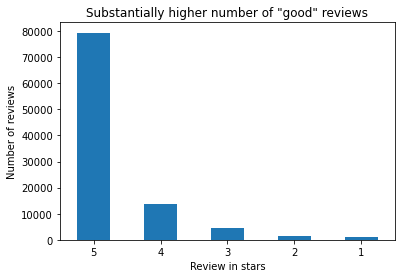

In [ ]:
# Visualization of the number of reviews posted for each star review (from 1 to 5)
%matplotlib inline
office_prods['overall'].value_counts().plot(kind = 'bar')
plt.xlabel('Review in stars')
plt.ylabel('Number of reviews')
plt.title('Substantially higher number of "good" reviews')
plt.xticks(rotation = 0)
plt.show()

### A second notion is that it is important to ensure that reviews are verified. Verified reviews would be reviews that have been checked as legitimate by Amazon. We ended up keeping verified and non-verified reviews.

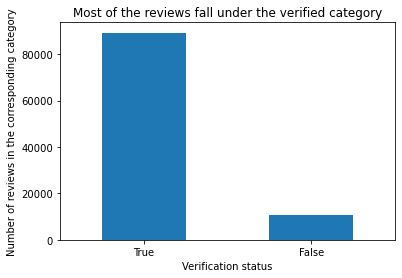

True     89231
False    10769
Name: verified, dtype: int64

In [ ]:
# Visualization of the number of reviews verified
%matplotlib inline
office_prods['verified'].value_counts().plot(kind = 'bar')
plt.xlabel('Verification status')
plt.ylabel('Number of reviews in the corresponding category')
plt.title('Most of the reviews fall under the verified category')
plt.xticks(rotation = 0)
plt.show()
office_prods['verified'].value_counts() #90170 unverified reviews 

In [ ]:
# Not sure how to describe the relevance of having unique reviewers but provided the code here
#(len(office_prods['reviewerID'].unique())/office_prods.shape[0])*100

## Data Cleaning
* deleting duplicate reviews
* applying stemming via SnowballStemmer nltk (natural language tool kit)
* expanding contractions ie don't is now do not
* removing stop words
* performing lemmatization on adjectives, verbs, nouns, and adverbs. 
* Incorporating phrases to further clean and identify elements of topics more accurately

### Here we are lowercasing all words, removing numbers, stemming words, removing stop words (and words we found to not be helpful), expanding out contractions and removing punctuation.

In [7]:
def clean_words(df, misc_words):
    df = df[df['reviewText'].notnull()]
    df['reviewText'].dropna(inplace=True)
    #  apply lowercase
    df['reviewText'] = df['reviewText'].str.lower()

    # Removing numbers
    df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(r'[0-9]', '', x))

    # Contractions
    df['no_contract'] = df['reviewText'].apply(lambda x: [contractions.fix(word) for word in x.split()])
    df['reviewText'] = [' '.join(map(str, l)) for l in df['no_contract']]
    df.drop(columns = 'no_contract', inplace = True)

    #  Remove the recurring unnecessary words like love, good, great seen in later analysis
    stop_words = stopwords.words('english')
    df['reviewText'] = df['reviewText'].apply(lambda x: [word for word in x.split() if word not in stop_words])
    df['reviewText'] = df['reviewText'].apply(lambda x: [word for word in x if word not in misc_words])

    
    #  Using only english words and replacing unknown words with 'UNK'
    #english_language = set(nltk.corpus.words.words())
    #df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join(w if w in english_language or not w.isalpha() else "UNK" for w in nltk.wordpunct_tokenize(x)))
    
    # Lemmatizing
    df['reviewText'] = df['reviewText'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Stemming data
    #stemmer = SnowballStemmer('english')
    #df['reviewText'] = df['reviewText'].apply(lambda x: [stemmer.stem(word) for word in x])

    #  Remove the recurring unnecessary words like love, good, great seen in later analysis
    df['reviewText'] = df['reviewText'].apply(lambda x: [word.lower() for word in x if word.lower() not in stop_words])
    df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([word for word in x if word not in misc_words]))

    #  tokenize the text and remove punctuation
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    df['no_punctuation'] = df['reviewText'].apply(lambda x: tokenizer.tokenize(x))
    df['reviewText'] = [' '.join(map(str, l)) for l in df['no_punctuation']]
                                              
    
    return df

In [8]:
office_prods = office_prods_orig.sample(50000, weights='overall', random_state=0).reset_index(drop=True)
# words that are not helpful
misc_words = ['love', 'great', 'good', 'can', 'would', 'like', 'work', 'recommend', 'much', 'better', 'highly', 'a']

In [ ]:
office_prods.to_clipboard()

In [9]:
office_prods = clean_words(office_prods, misc_words)
office_prods['reviewText']


0        give star performance time light button little...
1        larger staple arc notebook system taking note ...
2        shredder tremendous improvement several i ve t...
3                                                         
4        getting mark board quickly easily hammer nail ...
                               ...                        
49995    pens need color coding work i m pleased arrive...
49996    finished annual letter using paper delivers me...
49997    shredder everything say is two overstuffed box...
49998    difficult get excited paper unless talking hea...
49999    marker write bold beautiful color last long ti...
Name: reviewText, Length: 49986, dtype: object

### The tfidf vectorizer package is utilized to apply normalization to our review text as well as vectorize each review. Here we also are using a minimum number of documents for a word to appear. This is to further reduce the dimensions before applying tdidf to our review text. Finally, the review tokens are generated which will be used to support a dictionary.

In [10]:
#  vectorize the review text data

#  remove words that occur in less than 1% documents by setting the min_df parameter
min_df = int(0.01 * len(office_prods))

#  vectorize using tfidf
vectorizer = TfidfVectorizer(min_df=min_df) #  , stop_words = 'english', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b'
tfidf = vectorizer.fit_transform(office_prods['reviewText'])
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
print(tfidf.shape)

#  Get list of tokens from the reviews
office_prods = office_prods.reset_index(drop=True)
reviews_tokens = office_prods['no_punctuation']




(49986, 354)


In [11]:
len(vectorizer.vocabulary_)

354

In [12]:
reviews_tokens


0        [give, star, performance, time, light, button,...
1        [larger, staple, arc, notebook, system, taking...
2        [shredder, tremendous, improvement, several, i...
3                                                       []
4        [getting, mark, board, quickly, easily, hammer...
                               ...                        
49981    [pens, need, color, coding, work, i, m, please...
49982    [finished, annual, letter, using, paper, deliv...
49983    [shredder, everything, say, is, two, overstuff...
49984    [difficult, get, excited, paper, unless, talki...
49985    [marker, write, bold, beautiful, color, last, ...
Name: no_punctuation, Length: 49986, dtype: object

### Retrieve the phrases that are associated in topics like 'easy carry around' for instance

In [ ]:
#tokens = data['tokens'].tolist()
bigram_model = Phrases(reviews_tokens)
trigram_model = Phrases(bigram_model[reviews_tokens], min_count=1)
reviews_tokens_n_grams = list(trigram_model[bigram_model[reviews_tokens]])

In [ ]:
reviews_tokens[-5:]

49981    [pens, need, color, coding, work, pleased, arr...
49982    [finished, annual, letter, using, paper, deliv...
49983    [shredder, everything, say, is, two, overstuff...
49984    [difficult, get, excited, paper, unless, talki...
49985    [marker, write, bold, beautiful, color, last, ...
Name: no_punctuation, dtype: object

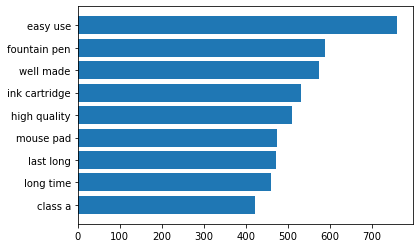

In [ ]:
#  Bigrams

length = 2
bigrams = []

for review in reviews_tokens:
    for i in range(length, len(review)):
        bigram = review[i - length: i]
        line = " ".join(bigram)
        bigrams.append(bigram)

bigrams = Counter(tuple(bigram) for bigram in iter(bigrams))

#  Get bigrams that occur more than 100 times / Top 10 bigrams
newDict = dict()
# Iterate over all (k,v) pairs in names
for key, value in bigrams.items():
    # Is condition satisfied?
    if value > 400:
        newDict[key] = value

#  Plot bigrams

lists = sorted(newDict.items(), key=lambda item: item[1]) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

x = [" ".join(bigram) for bigram in x]
y = np.array(y)

%matplotlib inline
plt.barh(np.arange(len(x)), y, tick_label=x)
plt.show()


In [ ]:
# #  Trigrams

# length = 3
# trigrams = []

# for review in reviews_tokens:
#     for i in range(length, len(review)):
#         trigram = review[i - length: i]
#         line = " ".join(trigram)
#         trigrams.append(trigram)

# trigrams = Counter(tuple(trigram) for trigram in iter(trigrams))


# #  Get bigrams that occur more than 100 times / Top 10 bigrams
# newDict = dict()
# # Iterate over all (k,v) pairs in names
# for key, value in trigrams.items():
#     # Is condition satisfied?
#     if value > 40:
#         newDict[key] = value

# #  Plot bigrams


# lists = sorted(newDict.items(), key=lambda item: item[1]) # sorted by key, return a list of tuples

# x, y = zip(*lists) # unpack a list of pairs into two tuples

# x = [" ".join(trigram) for trigram in x]
# y = np.array(y)

# %matplotlib inline
# plt.barh(np.arange(len(x)), y, tick_label=x)
# plt.show()

# Dimensionality Reduction and Clustering Analysis

#### PCA - from above, we use words_token, vectorized dataframe for dimensionality reduction

In [ ]:
tfidf.head()

,able,actually,add,advertised,again,all,almost,already,also,although,...,worked,working,worth,write,writes,writing,year,years,yet,you
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.167398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Performing Topic Modeling with Latent Semantic Analysis

## Topic Modeling

### These are the elements that are produced from the above data cleaning. A dictionary that has been pre processed and a document term matrix (or corpus) to be utilized within the models.

### The code below is taking the reviews and compiling them into the dictionary and document term matrix.

In [13]:
#  convert the tokenized reviews into a list of lists
reviews = reviews_tokens.tolist()
#option to use phrases
#reviews_n_grams = reviews_tokens_n_grams.copy()

#  create a dictionary out of it (texts_dict) - apply the min_df parameter here as well
dictionary = corpora.Dictionary(reviews)
dictionary.filter_extremes(no_below=min_df)

#  create a doc-term matrix (corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews]

len(dictionary.token2id)

359

### Topic Modeling with LDA

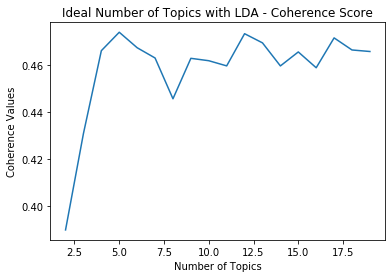

In [14]:
#  ---- Topic Modelling with LDA ----
# Visualization of the number of reviews verified
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/


n_topics = 20

coherence_vals = []

for topic in range(2, n_topics):
    #  run an LDA model for each topic value
    model = LdaModel(doc_term_matrix, num_topics=topic, id2word=dictionary)
    #  create a coherence model
    coherence_model = CoherenceModel(model=model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model.get_coherence())

x = range(2, n_topics)
%matplotlib inline
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Values")
plt.title('Ideal Number of Topics with LDA - Coherence Score')
plt.show()

In [27]:
#  Sticking to 5 topics as changing from 5 to 7 doesn't affect the coherence value much
n_topics = 6

lda = LdaModel(doc_term_matrix,id2word=dictionary,num_topics=n_topics)
topics = lda.print_topics(num_topics=n_topics, num_words=5)
for topic in topics:
    print(topic)

(0, '0.065*"paper" + 0.044*"quality" + 0.043*"price" + 0.037*"well" + 0.026*"perfect"')
(1, '0.106*"pen" + 0.044*"ink" + 0.044*"color" + 0.030*"write" + 0.026*"pens"')
(2, '0.036*"one" + 0.030*"use" + 0.029*"pencil" + 0.023*"phone" + 0.020*"card"')
(3, '0.026*"it" + 0.022*"one" + 0.019*"use" + 0.015*"get" + 0.014*"little"')
(4, '0.107*"product" + 0.053*"i" + 0.032*"a" + 0.029*"m" + 0.027*"price"')
(5, '0.079*"printer" + 0.042*"ink" + 0.037*"print" + 0.031*"cartridge" + 0.020*"printing"')


Text(0.5, 1.0, 'Topic Distributions')

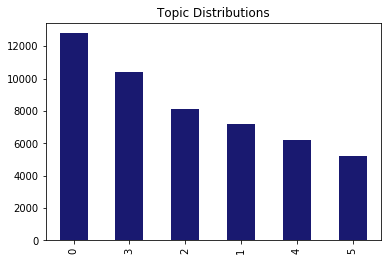

In [40]:
#  assigning topics to each review

topics = []
for review in reviews:
    bow = dictionary.doc2bow(review)
    topic = lda.get_document_topics(bow)
    assigned_topic = max(topic,key=itemgetter(1))[0]  
    topics.append(assigned_topic)

office_prods['topic'] = topics
set(topics)

#  Analysis

overall = office_prods.groupby(['overall']).agg(labels= ('topic', lambda x: x.value_counts().index[0]))


vote = office_prods.groupby(['vote']).agg(labels= ('topic', lambda x: x.value_counts().index[0]))
vote

%matplotlib inline
office_prods['topic'].value_counts(ascending=False).plot.bar(color='midnightblue')
plt.title('Topic Distributions')

In [28]:
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim_models.prepare(lda, corpus=doc_term_matrix, dictionary=dictionary)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.046795 -0.000650       1        1  26.784652
2     -0.015502  0.001714       2        1  20.672371
5     -0.083447  0.030487       3        1  16.243094
1     -0.106827 -0.169053       4        1  13.901627
0      0.212615 -0.030361       5        1  11.583921
4     -0.053634  0.167862       6        1  10.814336, topic_info=        Term         Freq         Total Category  logprob  loglift
95       pen  8346.000000   8346.000000  Default  30.0000  30.0000
107  product  6805.000000   6805.000000  Default  29.0000  29.0000
238  printer  7227.000000   7227.000000  Default  28.0000  28.0000
169      ink  7372.000000   7372.000000  Default  27.0000  27.0000
31     paper  7850.000000   7850.000000  Default  26.0000  26.0000
..       ...          ...           ...      ...      ...      ...
22      time   568.571918   5394.819932   Topic6  -4.6765  -0.0258
276     find   465.590098   2129.420229   Topic6  -4.8763   0.7040
81       use   614.805287  10731.467249   Topic6  -4.5983  -0.6353
205    color   539.733853   5512.023732   Topic6  -4.7286  -0.0993
27       lot   467.959937   2953.271301   Topic6  -4.8712   0.3820

[298 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
230       1  0.001015           a
230       3  0.002536           a
230       5  0.000507           a
230       6  0.996294           a
117       1  0.430083  advertised
...     ...       ...         ...
145       2  0.147711         you
145       3  0.062316         you
145       4  0.043852         you
145       5  0.529684         you
145       6  0.051930         you

[1132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 2, 1, 5])

In [ ]:
lda[doc_term_matrix[5]]

[(0, 0.05000345),
 (1, 0.050003793),
 (2, 0.5499322),
 (3, 0.05001506),
 (4, 0.050013926),
 (5, 0.050006714),
 (6, 0.050005414),
 (7, 0.050003156),
 (8, 0.050008506),
 (9, 0.050007798)]

In [ ]:
print(doc_term_matrix[-1])

[(7, 1), (22, 1), (84, 1), (92, 1), (102, 1), (103, 1), (174, 1), (178, 1), (179, 1), (188, 1), (204, 1), (217, 1), (334, 1), (346, 1)]


In [ ]:
print(reviews[-1])

['marker', 'write', 'bold', 'beautiful', 'color', 'last', 'long', 'time', 'quick', 'drying', 'others', 'keep', 'set', 'hand', 'always', 'cannot', 'beat']


In [ ]:
print(len(doc_term_matrix[2])), print(len(reviews[2]))

13
40


(None, None)

### Compiling the likelihood of each topic per review in order to understand which topics are present in each review. 
https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

In [41]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [42]:
topics = [lda[doc_term_matrix[i]] for i in range(len(office_prods))]

In [43]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=6) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [44]:
office_prods_with_topics = office_prods.join(document_topic)

office_prods_with_topics_mean_agg = office_prods_with_topics.groupby(['asin']).mean()

In [45]:
office_prods_with_topics_mean_agg.head()

,overall,verified,unixReviewTime,topic,0,1,2,3,4,5
asin,,,,,,,,,,
0310806607,5.0,1.0,1.405339e+09,2.0,0.448751,0.041717,0.072058,0.157751,0.235958,0.041669
0310806615,5.0,1.0,1.485043e+09,0.0,0.484712,0.033573,0.380810,0.033742,0.033555,0.033607
0310821800,5.0,1.0,1.476230e+09,1.5,0.537763,0.020995,0.020988,0.204289,0.120677,0.095289
0439499887,5.0,0.8,1.476697e+09,3.0,0.062585,0.062359,0.355265,0.161984,0.295414,0.062394
0439505399,5.0,1.0,1.383523e+09,3.0,0.218943,0.012944,0.217089,0.525190,0.012920,0.012912


### Looking at the share of topics within the documents as a whole
https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

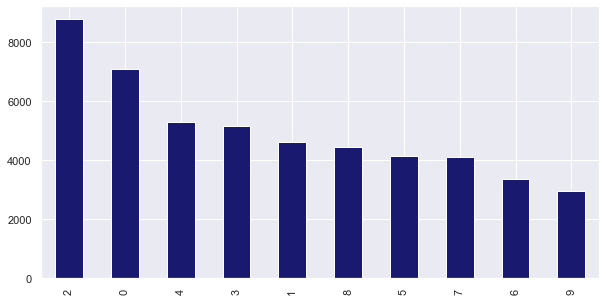

In [ ]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='midnightblue')

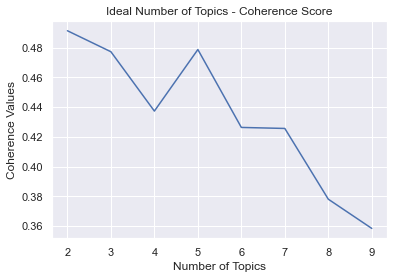

In [ ]:
#  ---- LSA with Gensim ----

#  convert the tokenized reviews into a list of lists
reviews = reviews_tokens.tolist()

#  create a dictionary out of it
dictionary = corpora.Dictionary(reviews)
dictionary.filter_extremes(no_below=min_df)

#  create a doc-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews]

#  create a gensim LSA model
n_topics = 10

#  get coherence scores to get the optimum number of topics
coherence_vals = []

for topic in range(2, n_topics):
    #  run an LSA model for each topic value
    model = LsiModel(doc_term_matrix, num_topics=topic, id2word=dictionary)
    #  create a coherence model
    coherence_model = CoherenceModel(model=model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model.get_coherence())

x = range(2, n_topics)
%matplotlib inline
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Values")
plt.title('Ideal Number of Topics - Coherence Score')
plt.show()


### With ideal number of topics decided, in this case 4, we can then prescribe labels to the word vectors below

In [ ]:
#  Keep the number of topics as 4
lsa = LsiModel(doc_term_matrix, num_topics=4, id2word=dictionary)

topics = lsa.print_topics(num_topics=4, num_words=10)

for topic in topics:
    print(topic)

(0, '0.346*"printer" + 0.259*"one" + 0.245*"ink" + 0.227*"use" + 0.225*"paper" + 0.179*"print" + 0.173*"pen" + 0.141*"color" + 0.123*"it" + 0.121*"time"')
(1, '0.597*"pen" + -0.575*"printer" + -0.247*"print" + -0.133*"printing" + -0.100*"cartridge" + 0.098*"writing" + 0.086*"use" + -0.085*"hp" + 0.084*"pens" + 0.080*"write"')
(2, '-0.499*"ink" + -0.475*"pen" + -0.285*"printer" + 0.181*"one" + 0.173*"phone" + 0.163*"use" + -0.142*"print" + -0.124*"cartridge" + 0.100*"product" + 0.098*"scanner"')
(3, '-0.507*"a" + -0.312*"link" + -0.185*"product" + -0.168*"class" + -0.164*"nbsp" + -0.157*"d" + -0.156*"data" + -0.155*"ref" + -0.155*"dp" + -0.154*"normal"')
